In [1]:
import re
import numpy as np
import glob
import csv
import os
import math
import cv2
import matplotlib.pyplot as plt

In [73]:
# 결과 저장경로 지정
f = open("../bf_img/Result.csv", 'w', newline='')
f.write("Img, Count, PosX, PosY, area, dia, hist_var, dark_mean, bright_mean, dark_max, bright_max, dark_min, bright_min, defect_gray_min, img_gray_min, dark_perc, bright_perc, classification, area_classification, eccen_PCA, eccen_Ell, Peri_Var\n")
wr = csv.writer(f)

(2182, 3086, 3)


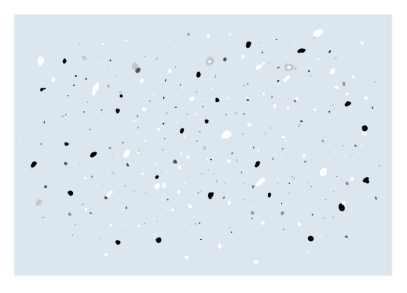

In [74]:
# 이미지 경로 지정
path = "../bf_img/"

# 이미지 목록 리스트로 반환 # 생성시간 기준으로 정렬
images = \
    [cv2.imread(file) for file in sorted(glob.glob(path+"*.JPG"),
    key=os.path.getmtime)]

image = images[0]
# image = image[250:1850, 300:2700]
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(img_rgb)


(1400, 1800)


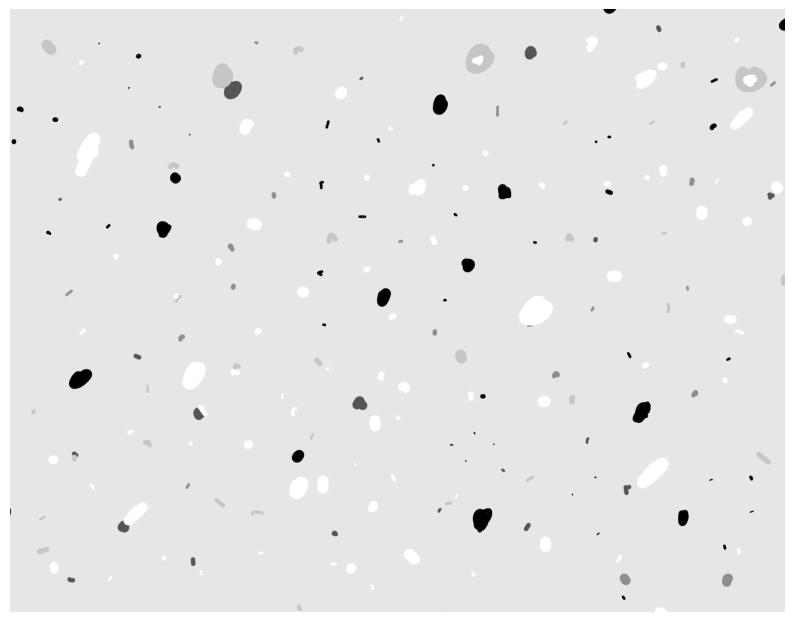

In [75]:
ori = img_rgb.copy()
# ori_img = img_rgb.copy()

# Crop
img = img_rgb.copy()
cropped_img = img[300:1700, 500:2300]
ori_img = cropped_img.copy()

# Color Split
img_b, img_g, img_r = cv2.split(ori_img)
ori_img_g = img_g.copy()
# img_g = cv2.medianBlur(ori_img_g, 3)

print(img_g.shape)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img_g, cmap='gray')

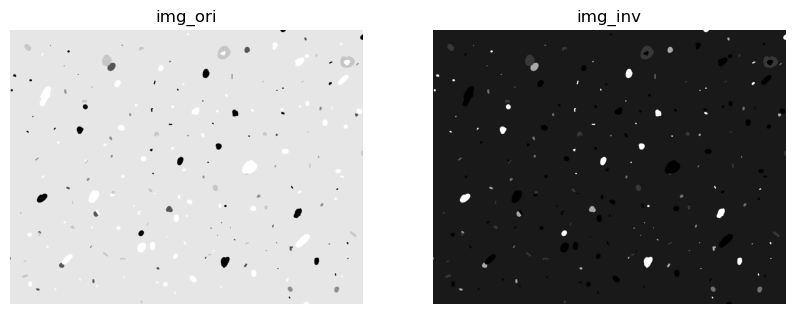

img_ori shape: (1400, 1800)
img_inv shape: (1400, 1800)


In [76]:
# Original img/ Inverse img 분리
img_ori = img_g.copy()
img_inv = 255 - img_ori


plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1) # (행의 수, 열의 수, 현재 위치)
plt.imshow(img_ori, cmap='gray')
plt.axis('off')
plt.title('img_ori')

plt.subplot(1, 2, 2)
plt.imshow(img_inv, cmap='gray')
plt.axis('off')
plt.title('img_inv')

plt.show()

print("img_ori shape:", img_ori.shape)
print("img_inv shape:", img_inv.shape)

img_add shape: (1400, 1800)


Text(0.5, 1.0, 'img_add')

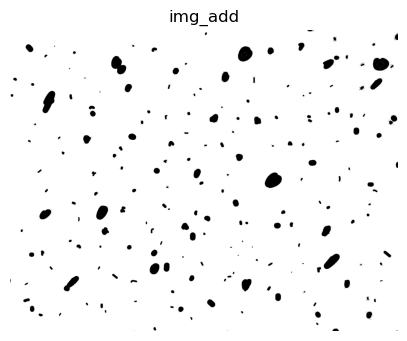

In [77]:
# Adaptive Threshold
block_size = 1801
C = 7
img_dark = cv2.adaptiveThreshold(img_ori, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)
img_bright = cv2.adaptiveThreshold(img_inv, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)
img_add = cv2.addWeighted(img_dark, 0.5, img_bright, 0.5, 0)

print('img_add shape:', img_add.shape)
plt.figure(figsize=(5,5))
plt.imshow(img_add, cmap='gray')
plt.axis('off')
plt.title('img_add')

In [78]:
# Median 필터
img_median = img_add.copy()
k_med = 3
med_img = cv2.medianBlur(img_median, k_med)
# Gaussian 필터
img_gaussian = med_img.copy()
k_gau = 3
gau_sigma = 1
gau_img = cv2.GaussianBlur(img_gaussian, (k_gau, k_gau), gau_sigma)

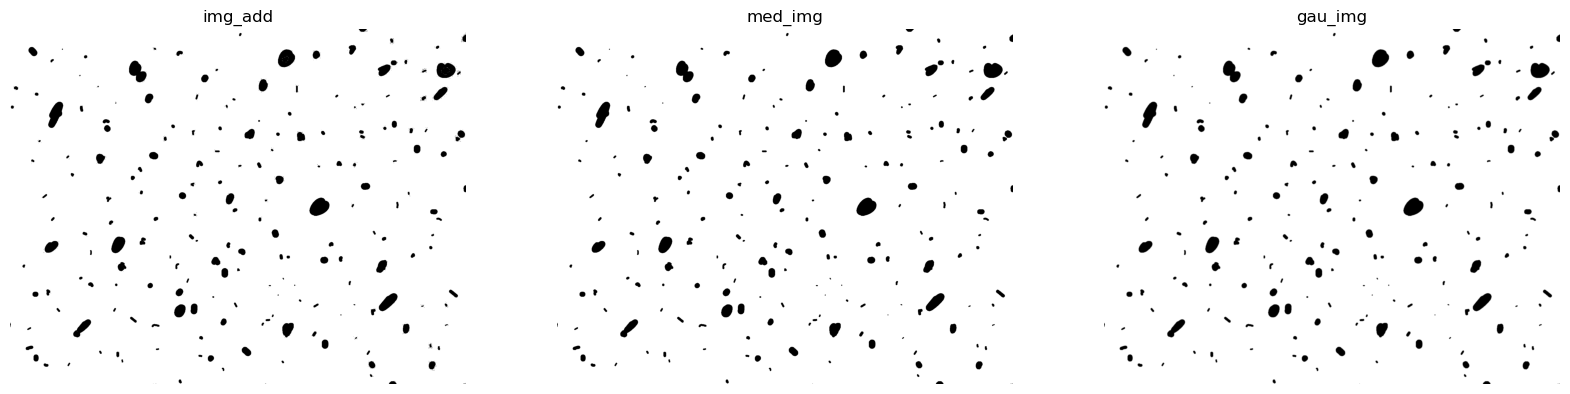

med_img shape: (1400, 1800)
gau_img shape: (1400, 1800)


In [79]:
plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1) # (행의 수, 열의 수, 현재 위치)
plt.imshow(img_add, cmap='gray')
plt.axis('off')
plt.title('img_add')

plt.subplot(1, 3, 2) 
plt.imshow(med_img, cmap='gray')
plt.axis('off')
plt.title('med_img')

plt.subplot(1, 3, 3)
plt.imshow(gau_img, cmap='gray')
plt.axis('off')
plt.title('gau_img')

plt.show()

print("med_img shape:", img_ori.shape)
print("gau_img shape:", img_inv.shape)

Text(0.5, 1.0, 'morph_close_img ')

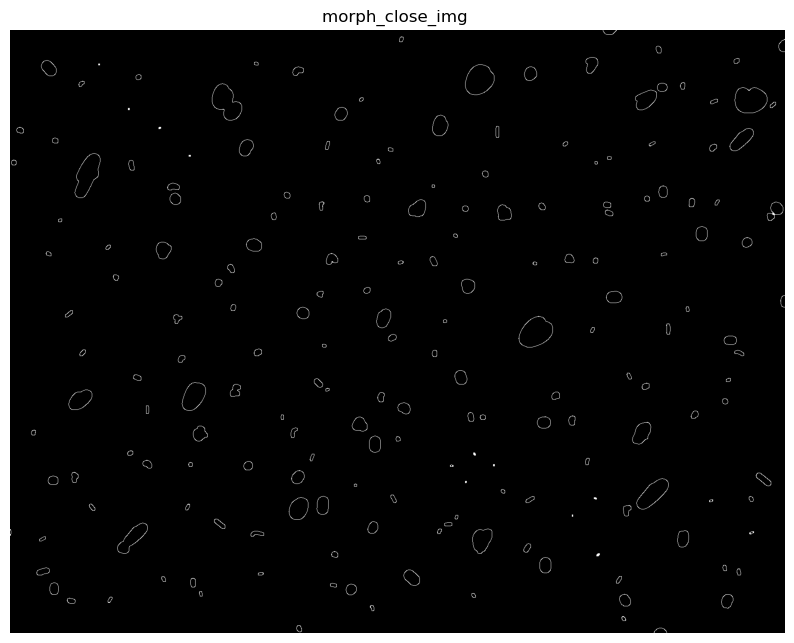

In [80]:
# Canny Edge Detection
def imageEdgeCanny(image):
    return cv2.Canny(image, 0, 255)
edg_img = imageEdgeCanny(gau_img)

# Blob
def morph_close(image):
    k_morph = 3
    kernel = np.ones((k_morph, k_morph), np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
morph_close_img = morph_close(edg_img).copy()

plt.figure(figsize=(10,10))
plt.imshow(morph_close_img , cmap='gray')
plt.axis('off')
plt.title('morph_close_img ')

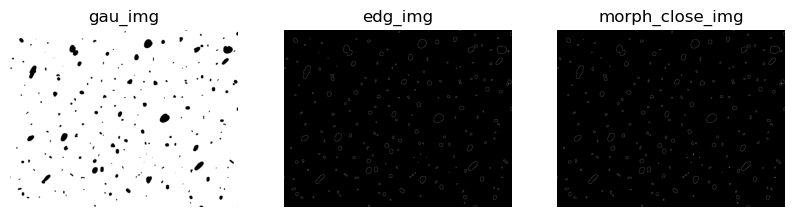

In [81]:
plt.figure(figsize=(10,10))

plt.subplot(1, 3, 1) # (행의 수, 열의 수, 현재 위치)
plt.imshow(gau_img, cmap='gray')
plt.axis('off')
plt.title('gau_img')

plt.subplot(1, 3, 2) 
plt.imshow(edg_img, cmap='gray')
plt.axis('off')
plt.title('edg_img')

plt.subplot(1, 3, 3)
plt.imshow(morph_close_img, cmap='gray')
plt.axis('off')
plt.title('morph_close_img')

plt.show()

Text(0.5, 1.0, 'cont_draw_img ')

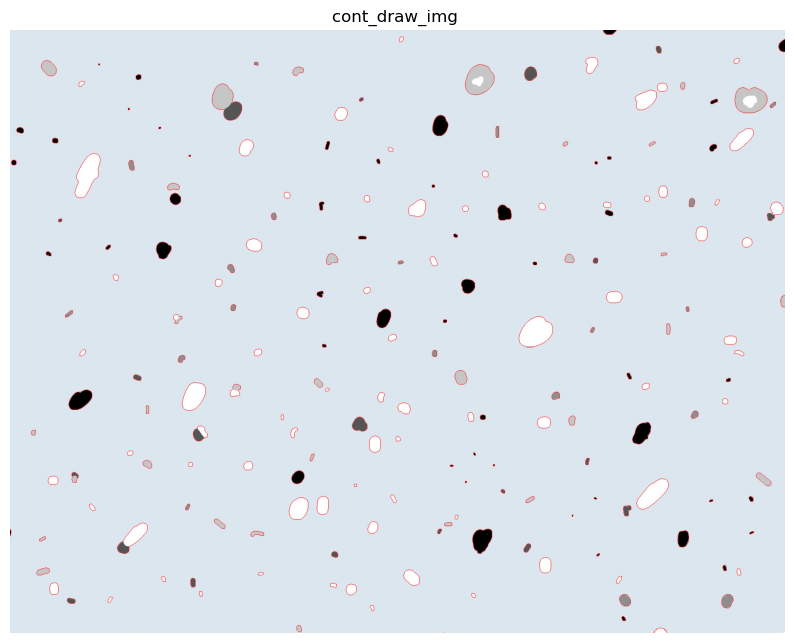

In [82]:
# Contours(외곽 Edge 찾기)-> Area/Position Meas.
cont_img = morph_close_img.copy()
contours, hierarchy = cv2.findContours(cont_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cont_draw_img = cropped_img.copy()
# cont_draw_img = np.zeros((1400, 1800))
for cnt in contours:
    cv2.drawContours(cont_draw_img, [cnt], -1, (255, 0, 0), 1)

plt.figure(figsize=(10,10))
plt.imshow(cont_draw_img , cmap='gray')
plt.axis('off')
plt.title('cont_draw_img ')

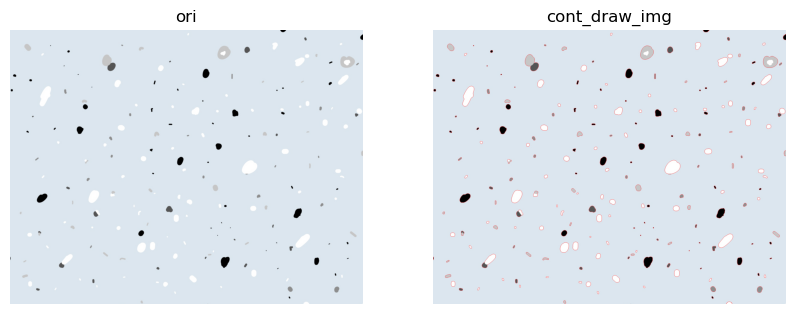

In [83]:
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1) # (행의 수, 열의 수, 현재 위치)
plt.imshow(ori_img, cmap='gray')
plt.axis('off')
plt.title('ori')

plt.subplot(1, 2, 2)
plt.imshow(cont_draw_img)
plt.axis('off')
plt.title('cont_draw_img')

plt.show()

In [84]:
# Contour 결과 이미지 저장
cont_draw_img = cv2.cvtColor(cont_draw_img , cv2.COLOR_RGB2BGR)
cv2.imwrite(f'../bf_img/rev_edge/result_img.bmp', cont_draw_img)

True

In [86]:
# Defect 미검출 결과 제외
if not contours:
    print("None", "None", "None", "None")
    wr.writerow([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, "X", "X", 0, 0, 0])
else:
    position = []
    area_arr = []
    dia_arr = []
    for k, cnt in enumerate(contours):
        cv2.drawContours(ori_img, [cnt], -1, (255, 255, 255), 0)
        # ZeroDivisionError 회피
        try:
            area = cv2.contourArea(cnt)
            M = cv2.moments(cnt)
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            pixelsize = 3.5
            Mag = 50
            dia = math.sqrt(4*(area * ((pixelsize / Mag) ** 2)) / (math.pi))
            dia = round(dia, 3)
            position.append([cx, cy])
            area_arr.append([area])
            dia_arr.append([dia])
        # ZeroDivisionError 회피
        except ZeroDivisionError: # contour가 라인
            print("ZeroDivision", "None", "None", "None")
            [k, cx, cy, area, dia, hist_var, dar_his_mean, bri_his_mean, dar_max, bri_max, dar_min, bri_min,
                dark_perc, bright_perc, \
                defect_gray_min, img_gray_min, classification, classification_area, eccen_PCA, eccen_Ell, dist_var] = \
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, "X", classification_area, 0, 0, 0]

    if np.array(position).shape == (0,):
        print("area=0", "None", "None", "None")
        [k, cx, cy, area, dia, hist_var, dar_his_mean, bri_his_mean, dar_max, bri_max, dar_min, bri_min, dark_perc,
            bright_perc, \
            defect_gray_min, img_gray_min, classification, classification_area, eccen_PCA, eccen_Ell, dist_var] = \
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, "X", classification_area, 0, 0, 0]
    else:
        img_center = np.array([490, 490])
        pos_diff = np.array(position) - np.array(img_center)
        pos_diff_x = pos_diff[:, 0]
        pos_diff_y = pos_diff[:, 1]
        pos_dist = np.sqrt(pos_diff_x ** 2 + pos_diff_y ** 2)
        roi_index = np.argmin(pos_dist)
        cnt = contours[roi_index]
        [cx, cy] = position[roi_index]
        [area] = area_arr[roi_index]
        [dia] = dia_arr[roi_index]

        print(k+1, cx, cy, area, dia)

        # Contour 외부 검정으로 만들기
        cnt_list = [np.array(contours[roi_index])]
        mask = np.zeros(ori_img_g.shape).astype(ori_img_g.dtype)
        color = [255, 255, 255]
        cv2.fillPoly(mask, cnt_list, color)
        result = cv2.bitwise_and(ori_img_g, mask) # True인 부분만 원래의 Gray 값을 갖는?

        # Histogram(Gray Level)
        hist_defect_cv = cv2.calcHist([result], [0], None, [255], [1, 256])  # openCV가 numpy보다 속도 빠름
        hist_defect = hist_defect_cv.ravel()

        # Histogram 분산
        hist_norm = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX)
        hist_equal = cv2.equalizeHist(result)
        hist = cv2.calcHist([hist_equal], [0], None, [256], [1, 255])
        hist_max = np.max(hist)
        hist_1 = hist/hist_max
        hist_var = round(np.var(hist_1), 4)

        # Background Gray 값 구하기
        bg_img = img_g.copy()
        bg_img = bg_img[50:100, 50:100]
        gray = np.mean(bg_img)
        a = gray

        # Histogram 평균,Max,Min
        index_dar = np.array([])
        index_bri = np.array([])
        index_gray = np.array([])
        dar_sum = 0
        bri_sum = 0
        dar_val_sum = 0
        bri_val_sum = 0
        for ind, val in enumerate(hist_defect):
            if ind < a:
                dar_sum = dar_sum + ind * val
                dar_val_sum = dar_val_sum + val
                dar_his_max = ind
                if val != 0:
                    index_dar = np.append(index_dar, [ind])
            else:
                bri_sum = bri_sum + ind * val
                bri_val_sum = bri_val_sum + val
                bri_his_max = ind
                if val != 0:
                    index_bri = np.append(index_bri, [ind])
            if val != 0:
                index_gray = np.append(index_gray, [ind])
        if dar_val_sum == 0:
            dar_his_mean = 0
            dar_his_max = 0
        else:
            dar_his_mean = round(dar_sum / dar_val_sum, 2)
        if bri_val_sum == 0:
            bri_his_mean = 0
            bri_his_max = 0
        else:
            bri_his_mean = round(bri_sum / bri_val_sum, 2)

        print("dar_his_mean", dar_his_mean)
        print("bri_his_mean", bri_his_mean)

        # Histogram Max
        index_dar = np.array([])
        index_bri = np.array([])
        for ind, val in enumerate(hist_defect):
            if ind < a:
                if val != 0:
                    index_dar = np.append(index_dar, [ind])
            else:
                if val != 0:
                    index_bri = np.append(index_bri, [ind])
        if len(index_dar) == 0:
            dar_max = 0
            dar_min = 0
        else:
            dar_max = np.max(index_dar)
            dar_min = np.min(index_dar)
        if len(index_bri) == 0:
            bri_max = 0
            bri_min = 0
        else:
            bri_max = np.max(index_bri)
            bri_min = np.min(index_bri)
        if len(index_gray) == 0:
            defect_gray_min = 0
        else:
            defect_gray_min = np.min(index_gray)

        print("dar_his_mean", dar_his_mean)
        print("bri_his_mean", bri_his_mean)
        print("dar_min", dar_min)
        print("bri_min", bri_min)

        # Defect Gray min
        index_gray_min = np.array([])
        for ind, val in enumerate(hist_defect):
            if val != 0:
                index_gray = np.append(index_gray_min, [ind])
        if len(index_gray_min) == 0:
            defect_gray_min = 0
        else:
            defect_gray_min = np.min(index_gray_min)

        # Dark, Bright percent
        gray_min = np.array(1, np.uint8)
        gray_thr_min = np.array(a, np.uint8)
        gray_thr_max = np.array(a, np.uint8)
        gray_max = np.array(255, np.uint8)
        dark = cv2.inRange(result, gray_min, gray_thr_min) # Range in: 255, Range out:0으로 반환
        num_dark = cv2.countNonZero(dark)
        bright = cv2.inRange(result, gray_thr_max, gray_max) # Range in: 255, Range out:0으로 반환
        num_bright = cv2.countNonZero(bright)
        dark_perc = round(num_dark / (num_dark + num_bright) * 100, 2)
        bright_perc = round(num_bright / (num_dark + num_bright) * 100, 2)
        print('dark: %.2f, bright: %.2f' % (dark_perc, bright_perc))

        # Area Gray min
        img_g_grey = img_g.ravel()
        img_gray_min = np.min(img_g_grey)

        # Defect_Classification
        if defect_gray_min > 121:
            classification = "BS"
        elif bright_perc == 100:
            classification = "BS"
        else:
            classification = "FS"
        # Area_Classification
        if img_gray_min > 121:
            classification_area = "BS"
        else:
            classification_area = "FS"
        print("Edge_classification", classification)
        print("Area_classificstion", classification_area)

        # PCA
        cnt_1 = cnt[:, 0]
        norm_cnt = cnt_1 - cnt_1.mean(axis=0)
        cov_norm_cnt = np.cov(norm_cnt.T)
        try:
            eigen_val, eigen_vec = np.linalg.eig(cov_norm_cnt)
        except np.linalg.LinAlgError:
            print('numpy.linalg.LinAlgError')
        v1 = eigen_val[0]
        v2 = eigen_val[1]
        if v1 > v2:
            eccen_PCA = round(math.sqrt(abs((v1 / 2) ** 2 - (v2 / 2) ** 2)) / (v1 / 2), 5)
        else:
            eccen_PCA = round(math.sqrt(abs((v1 / 2) ** 2 - (v2 / 2) ** 2)) / (v2 / 2), 5)
        print("eccen_PCA", eccen_PCA)

        # Ellipse_fitting
        cnt_1 = cnt[:, 0]
        if len(cnt_1) > 5:
            ellipse = cv2.fitEllipse(cnt_1)
        else:
            Ecx = 0
            Ecy = 0
            d1 = 0
            d2 = 0
            angle = 0
        (Ecx, Ecy), (d1, d2), angle = ellipse
        Ecx = int(Ecx)
        Ecy = int(Ecy)
        d1 = round(d1, 3) # 단축
        d2 = round(d2, 3) # 장축
        angle = int(angle)
        # print(Ecx, Ecy, d1, d2, angle)
        eccen_Ell = round(math.sqrt(abs((d1/2)**2-(d2/2)**2))/(d2/2), 4)
        print("eccen_Ell", eccen_Ell)

        # Perimeter Variation(distance variation)
        center = np.array([[cx, cy]])
        diff = cnt_1 - center
        diff_x = diff[:, 0]
        diff_y = diff[:, 1]
        distance = diff_x**2 + diff_y**2
        dist = np.sqrt(distance)
        peri_var = round(np.var(dist), 4)
        print("peri_var", peri_var)

    wr.writerow([k + 1, cx, cy, area, dia, hist_var, dar_his_mean, bri_his_mean, dar_max, bri_max, \
                    dar_min, bri_min, defect_gray_min, img_gray_min, dark_perc, bright_perc, classification,
                    classification_area, eccen_PCA, eccen_Ell, peri_var])
    
f.close()


197 513 553 227.0 1.19
dar_his_mean 150.66
bri_his_mean 226.43
dar_his_mean 150.66
bri_his_mean 226.43
dar_min 135.0
bri_min 223.0
dark: 90.59, bright: 9.41
Edge_classification FS
Area_classificstion FS
eccen_PCA 0.87388
eccen_Ell 0.7783
peri_var 2.4097
